0.0


1000.0


1414.213562373095


2236.06797749979


10000.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


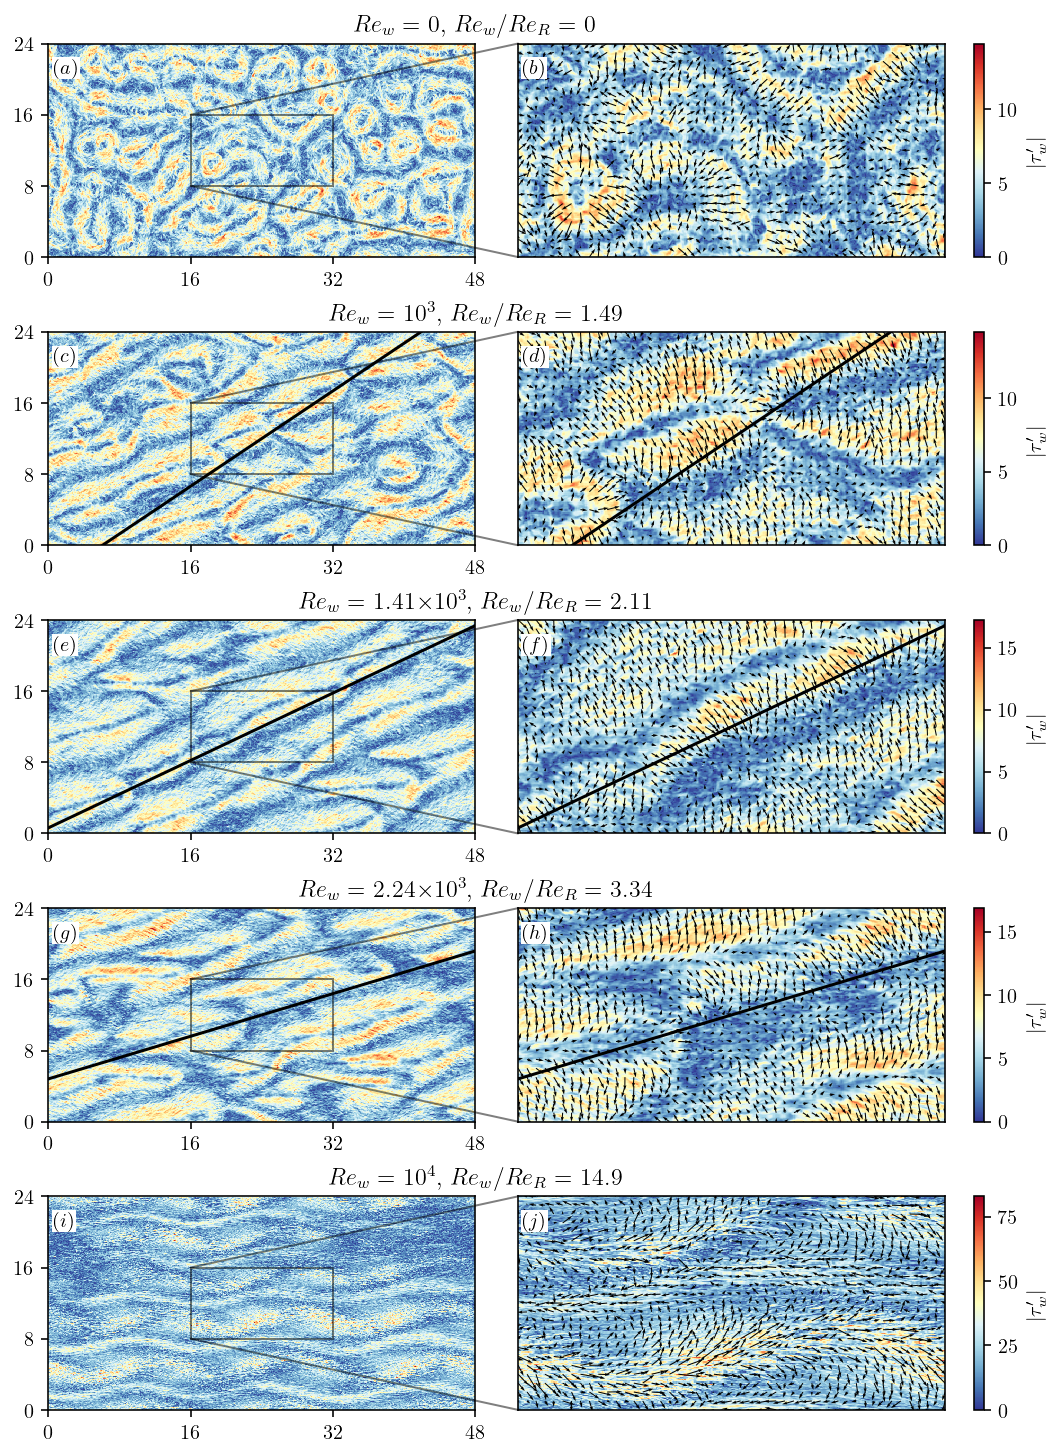

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as pl

from matplotlib import rc
rc('font',**{'family':'STIXGeneral','serif':['stix'],'size':10})
rc('text', usetex=True)

################################################################

def NSCI(number,decimal):
    if (number == 0):
        scstring = '{:.{decimal}g}'.format(0,decimal=decimal)
    elif (number==np.inf):
        scstring = r'\infty'
    else:
        exponent = int(np.log10(number))
        mantissa = number/(10**exponent)
        if (mantissa==1):
            scstring = '$10^{}$'.format(exponent)
        else:
            scstring = '{:.{decimal}g}'.format(mantissa,decimal=decimal)+r'$\times$'+'$10^{}$'.format(exponent)
    return(scstring)

def GET0(rootdir):
    strb = h5py.File('{}/Ri_Inf/stafield_master.h5'.format(rootdir),'r')
    Ra   = strb['Rayleigh Number'][:]
    Pr   = strb['Prandtl Number'][:]
    nu_e = (Pr/Ra)**0.5
    xcrb = strb['xc'][:]
    xmrb = strb['xm'][:]
    dxrb = xcrb[1:] - xcrb[:-1]
    avgt = strb['temp_m1'][0]
    vxm2 = strb['vx_m2'][:]/avgt
    vxm2 = np.pad(vxm2,(0,1),'constant',constant_values=0)
    vxm2 = 0.5*(vxm2[1:] + vxm2[:-1])
    vym2 = strb['vy_m2'][:]/avgt
    vzm2 = strb['vz_m2'][:]/avgt
    vlm2 = np.sum(dxrb*(vxm2 + vym2 + vzm2))
    vlm1 = vlm2**0.5
    R0   = vlm1/nu_e
    return(R0)

################################################################

alphabet = 'abcdefghijklmnopqrstuvwxyz'

rootdir = '../raw_data/CRB_Large/Ra1E+07_Pr1E+00'
Ra = 1E7
Pr = 1
Rf = (Ra/Pr)**0.5
R0 = GET0(rootdir)

Ri_list = [np.inf,10,5,2,0.1]
Rl_list = ['Inf','1E+01','5E+00','2E+00','1E-01']
Rg_list = ['Buoyancy-dominated', 'Transitional', 'Transitional', 'Transitional', 'Shear-dominated']

hfig = 2*len(Ri_list)
wfig = 8
fig,axs = pl.subplots(len(Ri_list),1,figsize=(wfig,hfig),constrained_layout=True)

ins = []
for ax in axs:
    ins += [ax.inset_axes([1.1, 0.0, 1.0, 1.0])]

for i,(Ri,Rl,Rg) in enumerate(zip(Ri_list,Rl_list,Rg_list)):

    Rw   = (Ra/(Ri*Pr))**0.5
    dtfl = h5py.File('{}/Ri_{}/shear_compressed.h5'.format(rootdir,Rl),'r')
    dkey = list(dtfl.keys())[0]
    data = dtfl[dkey]

    if (Rw > 0): Rs = (Ra**(1/2))*(Pr**(-5/6))
    else: Rs = 0

    print(Rw)

    m    = 8

    ym   = data['ym'][()]
    zm   = data['zm'][()]
    vyxb = data['vyxb'][()]
    vzxb = data['vzxb'][()]
    
    dtfl.close()
    
    vlxb = ((vyxb**2) + (vzxb**2))**0.5
    vlrm = (np.mean((vyxb**2) + (vzxb**2))**0.5)

    x00  = 24
    y00  = 12
    lll  = 48

    xb1  = x00 - lll*(np.cos(np.arctan2(R0,Rw)))
    yb1  = y00 - lll*(np.sin(np.arctan2(R0,Rw)))
    xb2  = x00 + lll*(np.cos(np.arctan2(R0,Rw)))
    yb2  = y00 + lll*(np.sin(np.arctan2(R0,Rw)))

    xf1  = x00 - 4*(np.cos(np.arctan2(R0,Rw)))
    yf1  = y00 - 4*(np.sin(np.arctan2(R0,Rw))) - 1
    xf2  = x00 + 4*(np.cos(np.arctan2(R0,Rw)))
    yf2  = y00 + 4*(np.sin(np.arctan2(R0,Rw))) - 1   

    xs1  = x00 - lll*(np.cos(np.arctan2(Rs,Rw)))
    ys1  = y00 - lll*(np.sin(np.arctan2(Rs,Rw)))
    xs2  = x00 + lll*(np.cos(np.arctan2(Rs,Rw)))
    ys2  = y00 + lll*(np.sin(np.arctan2(Rs,Rw)))

    ax = axs[i]
    im = ax.pcolormesh(zm,ym,vlxb,shading='nearest',cmap='RdYlBu_r',rasterized=True)
    if ((i>0) and (i<len(Ri_list)-1)): 
        ax.plot([xb1,xb2],[yb1,yb2],'k-')
    ax.set_xlim(0,48)
    ax.set_ylim(0,24)
    ax.set_xticks([0,16,32,48])
    ax.set_yticks([0,8,16,24])
    ax.set_aspect(1)
    ax.set_title(r'$Re_w = $'+' {}, '.format(NSCI(Rw,3)) + r'$Re_w/Re_R = $'+' {:.3g}'.format(Rw/R0[0]),position=(1.0,1.0))
    ax.text(0.01,0.86,'$({})$'.format(alphabet[2*i]),transform=ax.transAxes,bbox=dict(pad=0.5,facecolor='white',edgecolor='none',in_layout=True))

    cb = pl.colorbar(im,ax=ax)
    tk = cb.get_ticks()
    cb.set_ticks(tk[:-1])
    cb.ax.set_ylabel(r'$\left|\boldmath{\tau_w^\prime}\right|$')

    ix = ins[i]
    ix.pcolormesh(zm,ym,vlxb,shading='nearest',cmap='RdYlBu_r',rasterized=True)
    if ((i>0) and (i<len(Ri_list)-1)): 
        ix.plot([xb1,xb2],[yb1,yb2],'k-')
    ix.quiver(zm[::m],ym[::m],vzxb[::m,::m]/vlrm,vyxb[::m,::m]/vlrm,scale=50,color='k')
    ix.set_xlim(16,32)
    ix.set_ylim(8,16)
    ix.set_xticks([])
    ix.set_yticks([])
    ix.set_aspect(1)
    ix.text(0.01,0.86,'$({})$'.format(alphabet[2*i+1]),transform=ix.transAxes,bbox=dict(pad=0.5,facecolor='white',edgecolor='none',in_layout=True))

    ax.indicate_inset_zoom(ix,edgecolor="k",linewidth=1.0,alpha=0.5 )
    
    del(vyxb)
    del(vzxb)
    del(vlxb)

# pl.savefig('Shear.png',bbox_inches='tight',dpi=300)
# pl.savefig('Shear.pdf',bbox_inches='tight',dpi=300)
# pl.savefig('Shear.eps',bbox_inches='tight',dpi=300)
pl.show()
